In [4]:
import ngmix
import fitsio
import proplot as pplt
import numpy as np
import piff
import galsim
import yaml

In [5]:
%matplotlib inline

In [212]:
import glob
from esutil.pbar import PBar
import joblib

arrs = []
fnames = []
bands = []
arr_files = sorted(glob.glob("data/data_chunk*.fits"))
for arr_file in PBar(arr_files):
    fname_file = arr_file.replace("/data_", "/fnames_")
    arrs.append(fitsio.read(arr_file))
    fnames.append(fitsio.read(fname_file)["fnames"])
    bands.append([f.split("_")[1] for f in fnames[-1]])
    
arr = np.hstack(arrs)
fnames = np.hstack(fnames)
bands = np.hstack(bands)

print("any NaNs:", np.any(np.isnan(arr)))

|####################| 566/566 100% [elapsed: 00:21 left: 00:00]


any NaNs: True


In [213]:
def _plot_vals(arr, ax, title=None, msk=None):
    cols = pplt.get_colors("default")
    
    arr_bad = []
    arr_good = []
    arr_all = []
    isnan = []

    naninds = []
    cutinds = []
    oddinds = []

    def _stat(a):
        return np.nanmax(np.abs(a-np.nanmedian(a)))


    ng = 512
    for i in range(len(arr)//ng):
        if msk is not None and not msk[i]:
            continue
        start = i * ng
        stop = start + ng
        a = arr[start:stop]
        sa = _stat(a)
        if sa == 0:
            print("zero stat:", i)
            continue
        
        arr_all.append(sa)
        if np.any(np.isnan(a)):
            isnan.append(True)
            arr_bad.append(sa)
            naninds.append(i)
            print("really bad:", i, arr_bad[-1], np.any(np.isnan(a)))
        else:
            isnan.append(False)
            arr_good.append(sa)

            if sa > 0.14 and sa <= 0.15:
                oddinds.append(i)
                print("kind of odd:", i, sa)
            elif sa > 0.15:
                cutinds.append(i)

    cut = 0.15
    isnan = np.array(isnan)
    arr_all = np.array(arr_all)
    print("fraction cut:", np.mean(isnan | (arr_all > cut)))

    if len(arr_bad) > 0:
        arr_bad = np.log10(np.hstack(arr_bad))
    else:
        arr_bad = None
    arr_good = np.log10(np.hstack(arr_good))

    if arr_bad is not None:
        h, _, _ = ax.hist(
            [arr_bad, arr_good], 
            bins=75, 
            log=True, 
            density=False, 
            labels=["NaNs", "no NaNs"],
            colors=[cols[1], cols[0]],
            stacked=False,
            histtype="stepfilled",
            alpha=0.75,
        )
    else:
        h, _, _ = ax.hist(arr_good, bins=75, log=True, density=True, label="no NaNs", color=cols[0])
    
    ax.vlines(np.log10(cut), min(0.02, h.min()/2), max(h.max()*2, 1200), color='k')
    ax.legend()
    ax.set_xlabel("log10[max(|Tgal - median(Tgal)|)]")
    if title is not None:
        ax.set_title(title)
    ax.grid(False)

kind of odd: 122 0.14152161158217272
really bad: 194 0.5135791712573985 True
really bad: 495 6.256335880368863 True
kind of odd: 1038 0.1413302328575443
really bad: 1328 0.22659610481831238 True
really bad: 1777 0.18268463378281308 True
really bad: 2091 0.8130416325895122 True
really bad: 2274 0.16069257823615846 True
kind of odd: 2516 0.14063404993507822
really bad: 3008 0.10189541605961183 True
really bad: 4051 1.2946069825643765 True
really bad: 4255 0.6048523831126069 True
really bad: 4541 0.2566035896021767 True
really bad: 4845 0.20083140611054984 True
really bad: 5026 0.4590990837232982 True
really bad: 5342 0.4945738874630819 True
kind of odd: 5417 0.1442135692947446
really bad: 6312 0.09838307477523744 True
really bad: 6654 0.07392978336013739 True
really bad: 6730 0.2215086299768877 True
really bad: 6861 0.4315256506849744 True
really bad: 6984 1.2282837963698503 True
really bad: 7508 0.11346213683427464 True
really bad: 7515 0.4260560016109637 True
kind of odd: 7536 0.144334

/gpfs02/astro/workarea/beckermr/miniconda3/envs/desy6/lib/python3.9/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


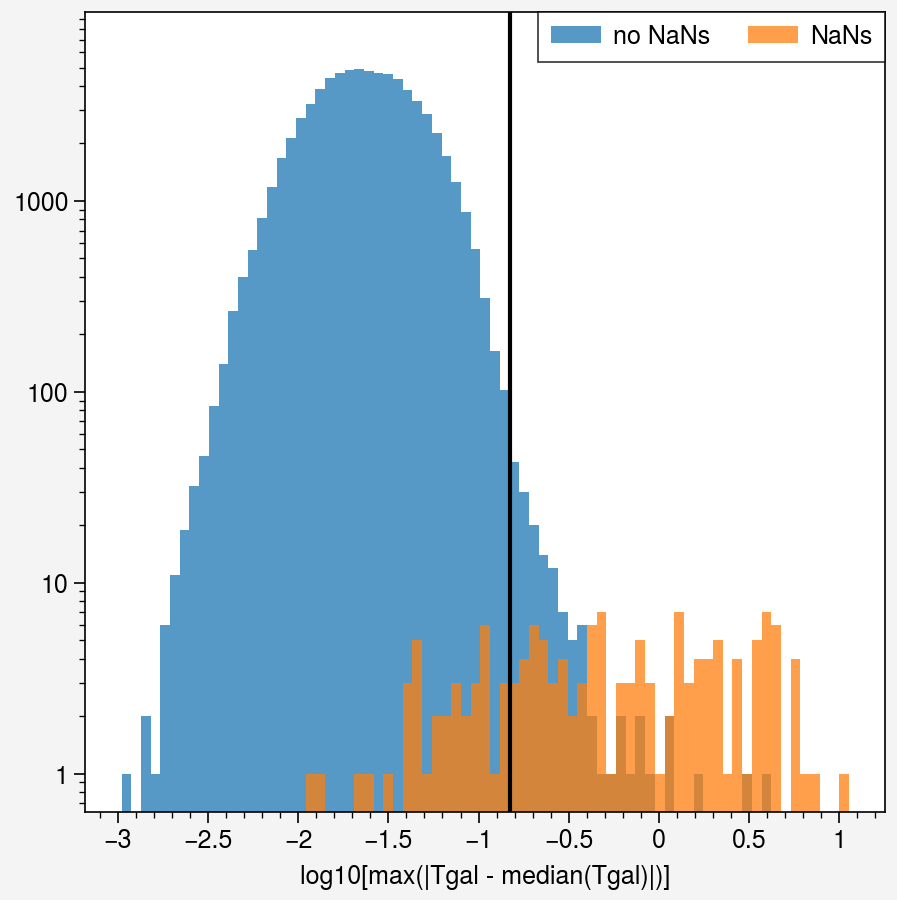

In [214]:
fig, axs = pplt.subplots(refwidth=4)
_plot_vals(arr, axs)

kind of odd: 1038 0.1413302328575443
really bad: 1777 0.18268463378281308 True
really bad: 2274 0.16069257823615846 True
kind of odd: 2516 0.14063404993507822
really bad: 3008 0.10189541605961183 True
really bad: 4051 1.2946069825643765 True
really bad: 4255 0.6048523831126069 True
really bad: 4541 0.2566035896021767 True
kind of odd: 5417 0.1442135692947446
really bad: 6312 0.09838307477523744 True
really bad: 6861 0.4315256506849744 True
really bad: 6984 1.2282837963698503 True
really bad: 7515 0.4260560016109637 True
kind of odd: 7549 0.1466087777466878
really bad: 9502 0.4225603856789999 True
kind of odd: 11472 0.14705823620228475
really bad: 12033 1.6320077893756988 True
really bad: 12957 0.1375554842076273 True
really bad: 14039 3.511693428977728 True
really bad: 14415 0.43843673252848914 True
really bad: 16160 0.5071652923170542 True
really bad: 16545 0.37933352728342623 True
really bad: 16576 0.19730449589996568 True
kind of odd: 16938 0.14940511413262159
really bad: 17283 0.78

/gpfs02/astro/workarea/beckermr/miniconda3/envs/desy6/lib/python3.9/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


really bad: 4845 0.20083140611054984 True
really bad: 5026 0.4590990837232982 True
really bad: 6730 0.2215086299768877 True
kind of odd: 7536 0.14433490497849238
really bad: 7837 3.712250245884835 True
kind of odd: 8127 0.1493121033276702
really bad: 12120 3.7246777795185846 True
kind of odd: 14112 0.14261802577153615
really bad: 15790 0.3112968900344183 True
really bad: 18216 1.2815023233793856 True
really bad: 18408 0.3288807150381765 True
really bad: 20139 2.1983346519339193 True
really bad: 20760 1.5780160809500199 True
really bad: 22231 0.213560328902886 True
really bad: 25926 0.9464999269401155 True
kind of odd: 27423 0.14183873223803523
really bad: 31975 1.849147783527743 True
really bad: 33990 1.3744949721692854 True
really bad: 34081 0.09565077639940522 True
really bad: 36613 2.5949479404504063 True
really bad: 38002 0.03809699731091387 True
really bad: 39112 1.0293693423159604 True
really bad: 40115 0.4706256752163094 True
really bad: 43009 0.8057949480971265 True
really bad:

/gpfs02/astro/workarea/beckermr/miniconda3/envs/desy6/lib/python3.9/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


kind of odd: 122 0.14152161158217272
really bad: 6654 0.07392978336013739 True
really bad: 8884 1.9740045063090834 True
really bad: 12809 0.10329423638104246 True
really bad: 14422 0.08907454167961948 True
really bad: 17183 0.03284480601375683 True
really bad: 18497 0.07969697363312112 True
really bad: 19021 0.6230177651027535 True
really bad: 20624 0.10930607926990332 True
really bad: 21465 1.5574223492312482 True
really bad: 22098 0.0389577830799539 True
really bad: 22506 0.05974669793752996 True
really bad: 22823 1.9689199549921463 True
really bad: 23009 0.1553496500838375 True
really bad: 23816 2.5182631862215965 True
really bad: 26273 0.013312436733502464 True
really bad: 27640 4.15665813085188 True
really bad: 33225 1.7487248800782011 True
really bad: 33472 6.937835503691985 True
really bad: 36451 0.012278970384916293 True
really bad: 40358 4.34746928855466 True
really bad: 40963 3.808823508009411 True
really bad: 41533 0.06377248743972613 True
really bad: 44413 0.024949325606710

/gpfs02/astro/workarea/beckermr/miniconda3/envs/desy6/lib/python3.9/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


really bad: 5342 0.4945738874630819 True
really bad: 7508 0.11346213683427464 True
kind of odd: 10879 0.14745809708190194
really bad: 19165 0.16716384914152435 True
kind of odd: 19271 0.14491580166487983
really bad: 20074 0.1796784097785371 True
really bad: 22973 0.1846570886320288 True
really bad: 25871 0.02199908484018237 True
really bad: 28510 0.05894987165477655 True
really bad: 29264 0.11091447561003365 True
really bad: 31199 1.7026364665816947 True
kind of odd: 40675 0.14437605416404198
really bad: 40781 3.295035656702091 True
really bad: 41569 0.03958107947398071 True
really bad: 45228 0.0641927402527567 True
really bad: 45713 4.671923462071524 True
really bad: 50425 4.443102863802176 True
really bad: 58658 0.2559176090522515 True
really bad: 61797 1.5067048662160867 True
really bad: 62083 0.7664559817579436 True
really bad: 63256 0.40570390773639486 True
really bad: 65701 3.122240115266474 True
really bad: 70547 1.9212941354058548 True
really bad: 70773 6.018362001860667 True
f

/gpfs02/astro/workarea/beckermr/miniconda3/envs/desy6/lib/python3.9/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


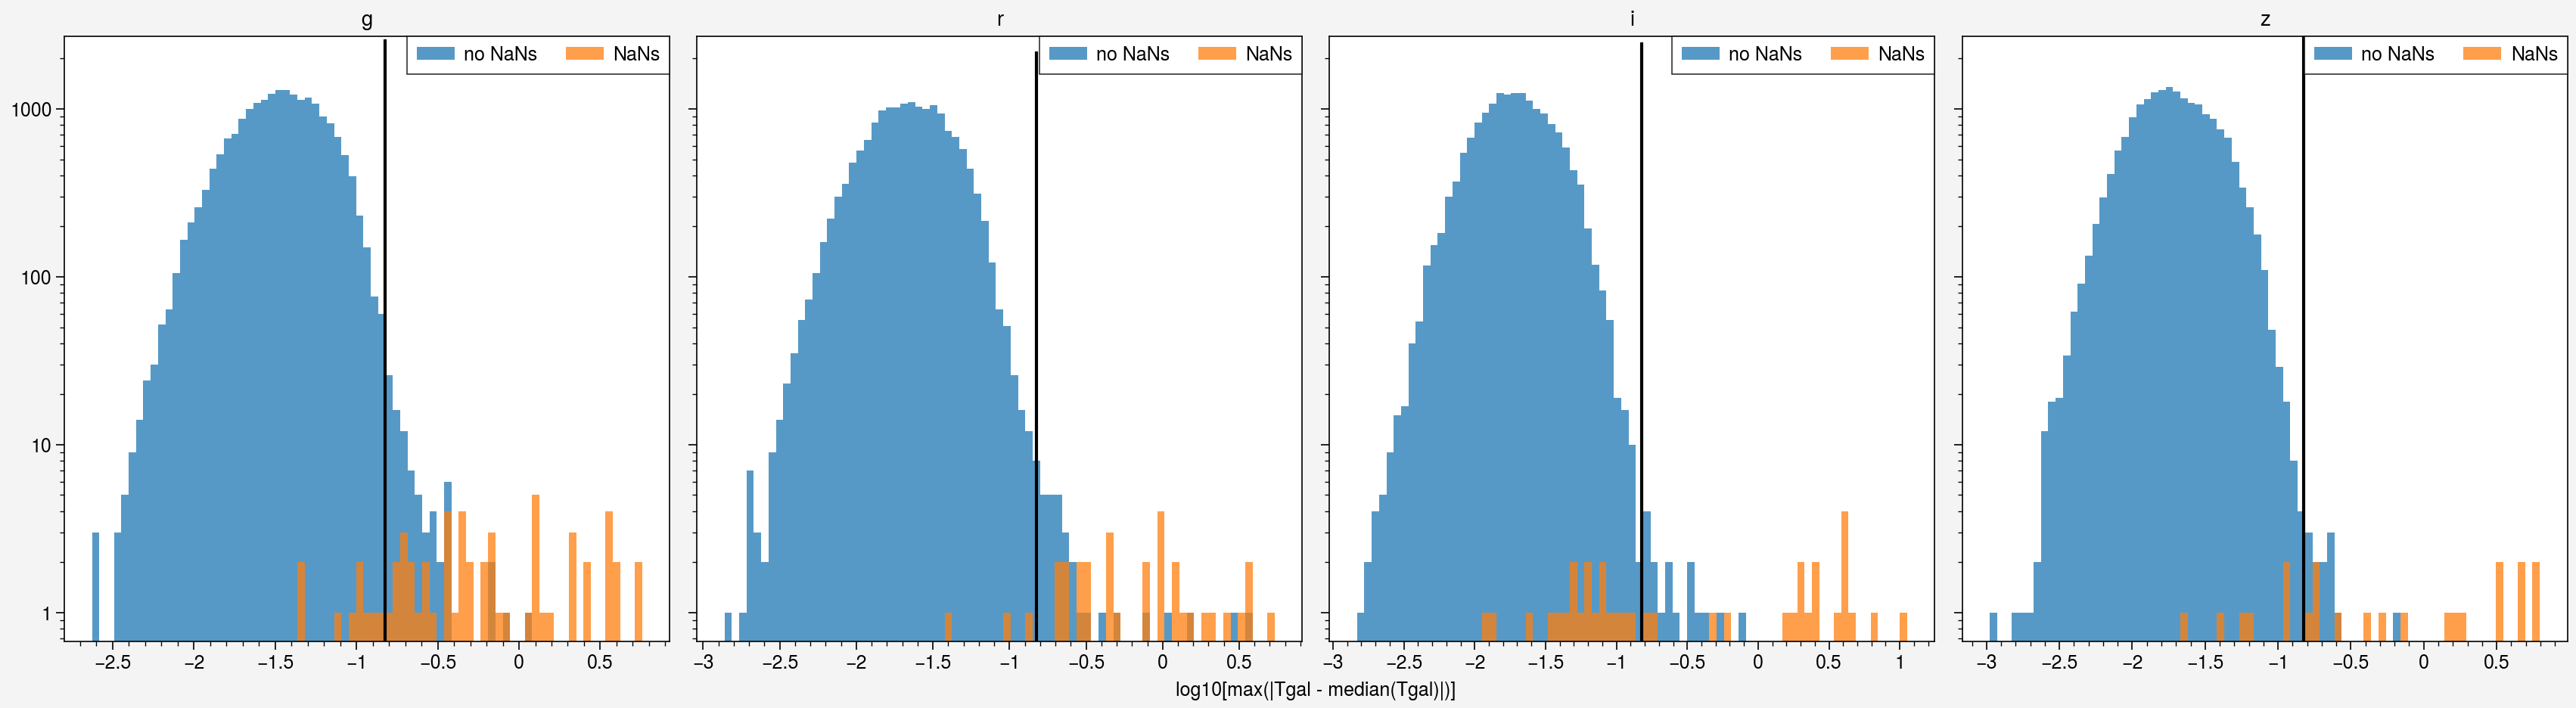

In [215]:
fig, axs = pplt.subplots(refwidth=4, ncols=4)

for i, band in enumerate(["g", "r", "i", "z"]):
    msk = bands == band 
    _plot_vals(arr, axs[i], title=band, msk=msk)

96


Text(0.5, 1.0, 'grid of shapes at gal color')

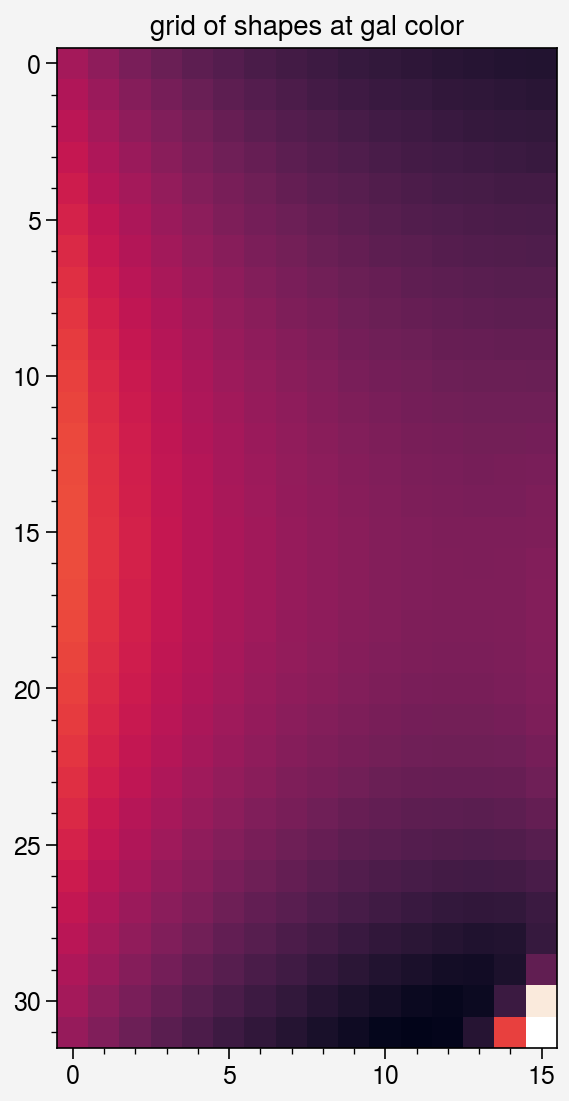

In [115]:
import os
import glob
from des_y6utils.piff import (
    measure_star_t_for_piff_model,
    map_star_t_to_grid,
    measure_t_grid_for_piff_model,
    make_good_regions_for_piff_model_gal_grid,
    make_good_regions_for_piff_model_star_and_gal_grid,
    nanmad,
)

sind = 3008
found = glob.glob(os.path.join(os.environ["DESDATA"], "**", fnames[sind]), recursive=True)
assert len(found) == 1

piff_mod = piff.read(found[0])
print(len(piff_mod.stars))

if "_z_" in fnames[sind]:
    piff_kwargs = {"IZ_COLOR": 0.34}
else:
    piff_kwargs = {"GI_COLOR": 0.61}

t_arr = measure_t_grid_for_piff_model(piff_mod, piff_kwargs, seed=14354)

fig, axs = pplt.subplots(ncols=1, share=0)
axs.imshow(t_arr, cmap="rocket")
axs.grid(False)
axs.set_title("grid of shapes at gal color")

71


Text(0.5, 0, 'gal T - star T')

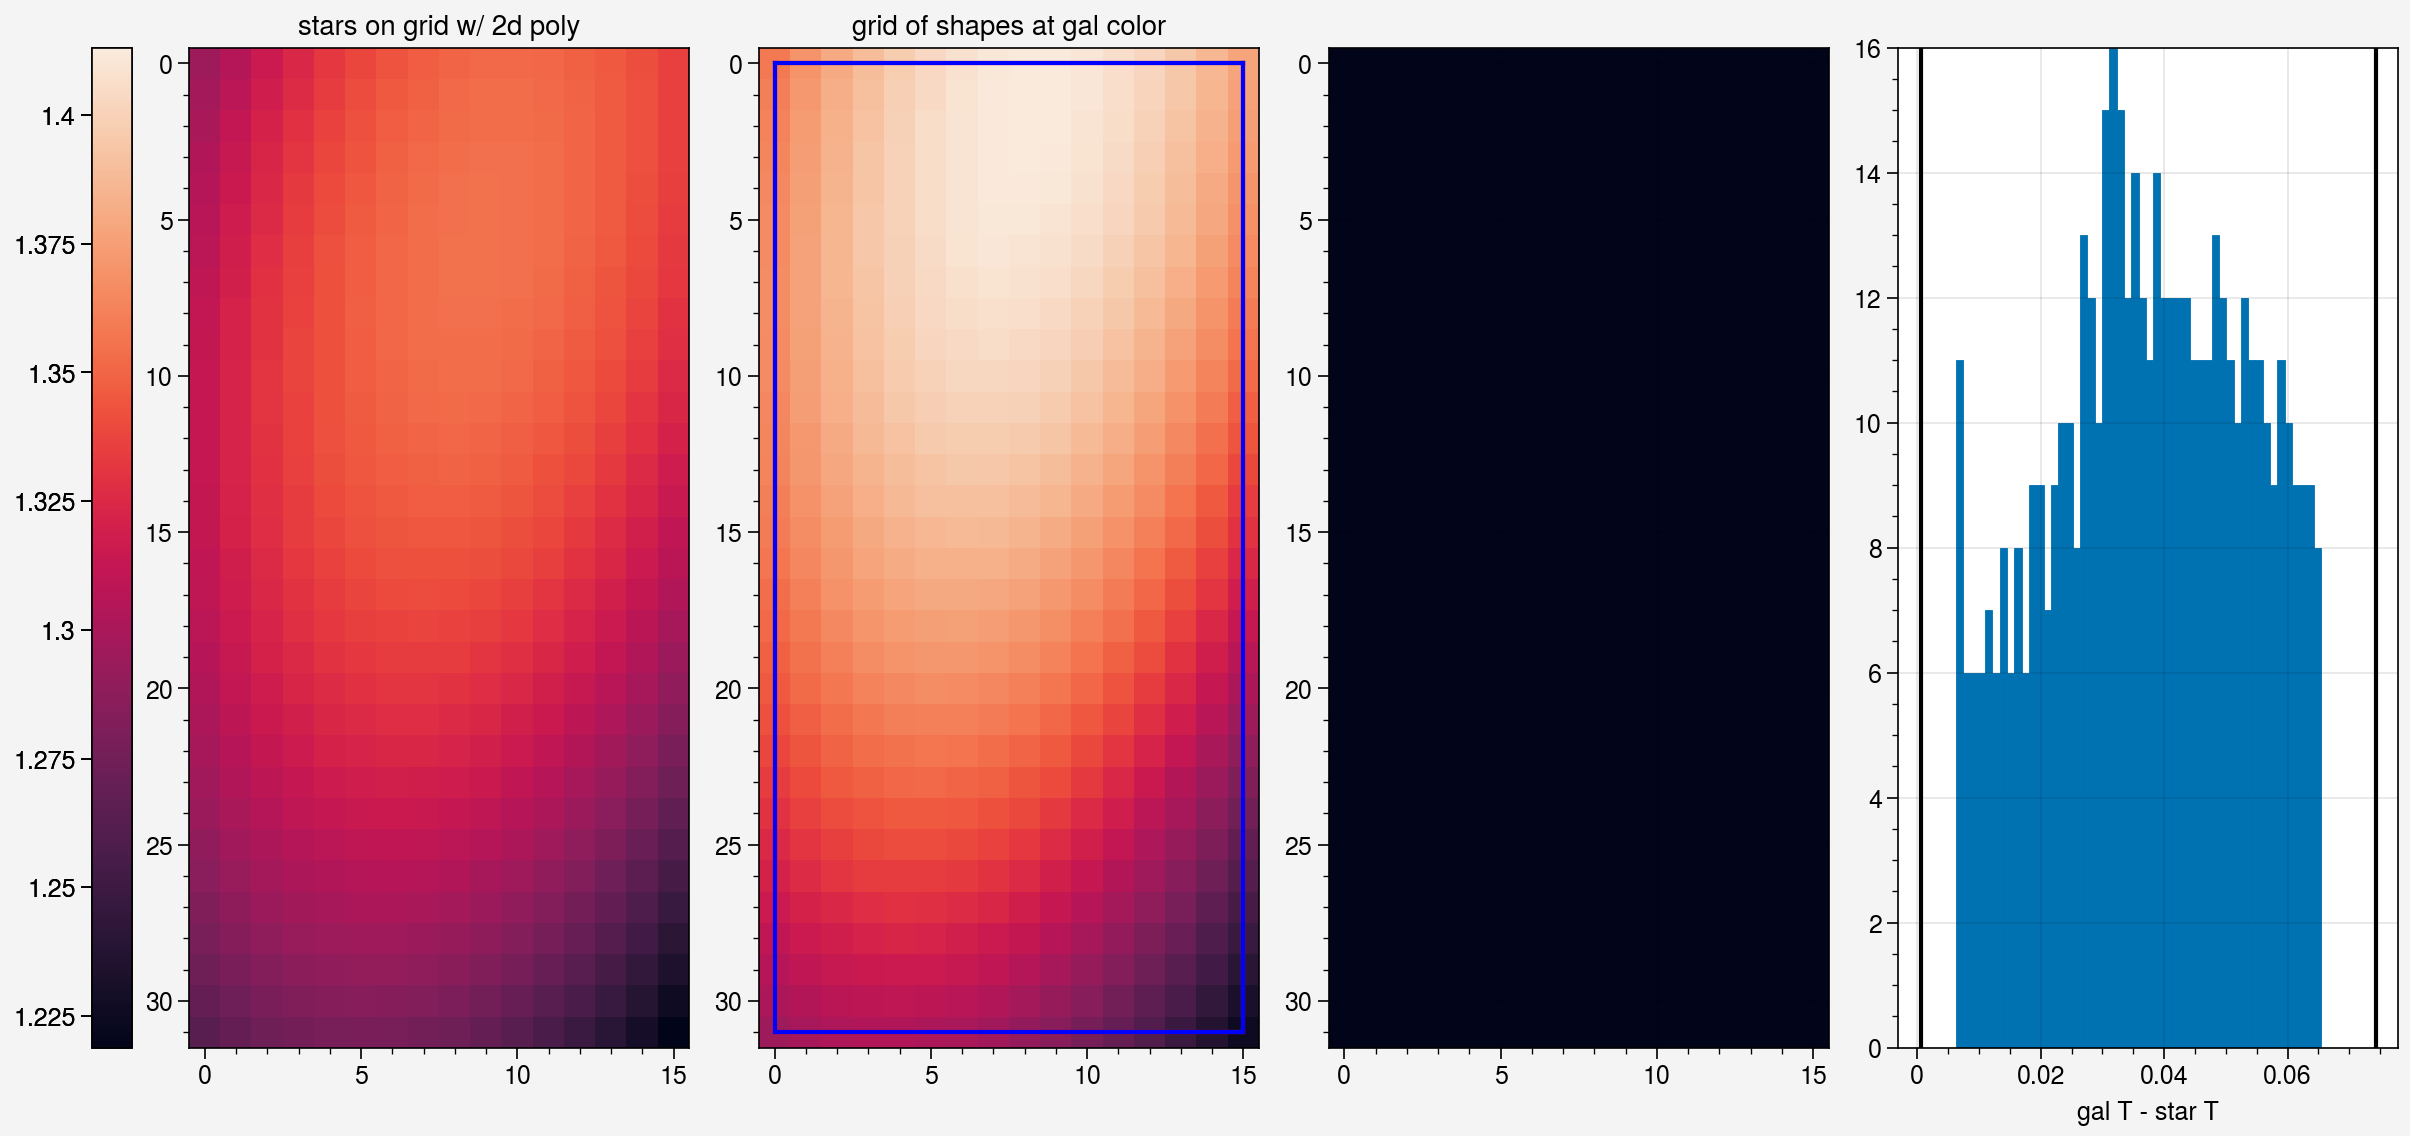

In [122]:
import os
import glob
from des_y6utils.piff import (
    measure_star_t_for_piff_model,
    map_star_t_to_grid,
    measure_t_grid_for_piff_model,
    make_good_regions_for_piff_model_gal_grid,
    make_good_regions_for_piff_model_star_and_gal_grid,
    nanmad,
)

sind = 2516
found = glob.glob(os.path.join(os.environ["DESDATA"], "**", fnames[sind]), recursive=True)
assert len(found) == 1


piff_mod = piff.read(found[0])
print(len(piff_mod.stars))

if "_z_" in fnames[sind]:
    piff_kwargs = {"IZ_COLOR": 0.34}
else:
    piff_kwargs = {"GI_COLOR": 0.61}


thresh = 5
t_arr = measure_t_grid_for_piff_model(piff_mod, piff_kwargs, seed=14354)
data = measure_star_t_for_piff_model(piff_mod, piff_prop=list(piff_kwargs.keys())[0])
msk = np.isfinite(data["t"])
data = data[msk]
ts_arr = map_star_t_to_grid(data)

res_g = make_good_regions_for_piff_model_gal_grid(piff_mod, piff_kwargs=piff_kwargs, seed=11, verbose=False)
res_sg = make_good_regions_for_piff_model_star_and_gal_grid(
    piff_mod, piff_kwargs=piff_kwargs, seed=11, verbose=False,
    flag_bad_thresh=2, any_bad_thresh=5,
)

vmin = min(np.nanmin(ts_arr), np.nanmin(t_arr))
vmax = max(np.nanmax(ts_arr), np.nanmax(t_arr))

fig, axs = pplt.subplots(ncols=4, share=0)
h0 = axs[0].imshow(ts_arr, vmin=vmin, vmax=vmax, cmap="rocket")
axs[0].grid(False)
axs[0].set_title("stars on grid w/ 2d poly")
axs[0].colorbar(h0, loc='l')

axs[1].imshow(t_arr, vmin=vmin, vmax=vmax, cmap="rocket")
axs[1].grid(False)
axs[1].set_title("grid of shapes at gal color")

b = res_g["bbox"]
axs[1].plot([b["xmin"]/128, b["xmin"]/128], [b["ymin"]/128, b["ymax"]/128 - 1], color="red")
axs[1].plot([b["xmax"]/128 - 1, b["xmax"]/128 - 1], [b["ymin"]/128, b["ymax"]/128 - 1], color="red")
axs[1].plot([b["xmin"]/128, b["xmax"]/128 - 1], [b["ymin"]/128, b["ymin"]/128], color="red")
axs[1].plot([b["xmin"]/128, b["xmax"]/128 - 1], [b["ymax"]/128 - 1, b["ymax"]/128 - 1], color="red")

b = res_sg["bbox"]
axs[1].plot([b["xmin"]/128, b["xmin"]/128], [b["ymin"]/128, b["ymax"]/128 - 1], color="blue")
axs[1].plot([b["xmax"]/128 - 1, b["xmax"]/128 - 1], [b["ymin"]/128, b["ymax"]/128 - 1], color="blue")
axs[1].plot([b["xmin"]/128, b["xmax"]/128 - 1], [b["ymin"]/128, b["ymin"]/128], color="blue")
axs[1].plot([b["xmin"]/128, b["xmax"]/128 - 1], [b["ymax"]/128 - 1, b["ymax"]/128 - 1], color="blue")

axs[2].imshow(res_sg["bad_msk"], cmap="rocket")

harr = (t_arr-ts_arr).ravel()
std5 = nanmad(harr) * 2
h = axs[3].hist(harr, bins=50)
axs[3].vlines([np.nanmedian(harr)-std5, np.nanmedian(harr)+std5], 0, np.max(h[0]), color="k")
axs[3].set_xlabel("gal T - star T")

In [ ]:
TNAMES = ["DES0131-3206", "DES0137-3749", "DES0221-0750", "DES0229-0416"]
BANDS = ["g", "r", "i", "z"]

with open(
    "/Users/beckermr/MEDS_DIR/des-pizza-slices-y6-test/pizza_cutter_info/"
    "%s_%s_pizza_cutter_info.yaml" % (TNAMES[1], BANDS[0])
) as fp:
    yml = yaml.safe_load(fp.read())

In [ ]:
from des_y6utils.piff import (
    measure_star_t_for_piff_model,
    map_star_t_to_grid,
    measure_t_grid_for_piff_model,
    make_good_regions_for_piff_model_gal_grid,
    make_good_regions_for_piff_model_star_and_gal_grid,
    nanmad,
)

In [ ]:
# find a bad model
import tqdm

for sind, src in tqdm.tqdm(enumerate(yml["src_info"]), total=len(yml["src_info"])):
    fname = src["piff_path"]

    pmod = piff.read(fname)
    if "_z_" in fname:
        piff_kwargs = {"IZ_COLOR": 0.34}
    else:
        piff_kwargs = {"GI_COLOR": 0.61}
    t_gal = measure_t_grid_for_piff_model(piff_mod, piff_kwargs, seed=14354)    
    bf = np.mean(np.isnan(t_gal))
    
    if bf > 0:
        print(sind)
        break

In [ ]:
from esutil.pbar import prange
from pizza_cutter.des_pizza_cutter._piff_tools import compute_piff_flags

tot = 0
flagged = 0

TNAMES = ["DES0131-3206", "DES0137-3749", "DES0221-0750", "DES0229-0416"]
BANDS = ["g", "r", "i", "z"]


for i in prange(4):
    for j in range(4):
        with open(
            "/Users/beckermr/MEDS_DIR/des-pizza-slices-y6-test/pizza_cutter_info/"
            "%s_%s_pizza_cutter_info.yaml" % (TNAMES[i], BANDS[j])
        ) as fp:
            yml = yaml.safe_load(fp.read())
        
        for _sind, src in enumerate(yml["src_info"]):
            tot += 1
            if (compute_piff_flags(
                        piff_info=src["piff_info"],
                        max_fwhm_cen=3.6, 
                        min_nstar=35, 
                        max_exp_T_mean_fac=4, 
                        max_ccd_T_std_fac=0.3,
                    ) != 0):
                flagged += 1

print(flagged, flagged / tot)

In [ ]:
from pizza_cutter.des_pizza_cutter._piff_tools import compute_piff_flags

TNAMES = [
    "DES0131-3206", 
    "DES0137-3749", 
    "DES0221-0750", 
    "DES0229-0416",
]

tfind = "D00372620_i_c62_r5702p01_piff-model.fits"
BANDS = [tfind.split("_")[1]]
sind = None

for band in BANDS:
    for tname in TNAMES:
        with open(
            "/Users/beckermr/MEDS_DIR/des-pizza-slices-y6-test/pizza_cutter_info/"
            "%s_%s_pizza_cutter_info.yaml" % (tname, band)
        ) as fp:
            yml = yaml.safe_load(fp.read())

        for _sind, src in enumerate(yml["src_info"]):
            if tfind in src["piff_path"]:
                sind = _sind
                print(
                    "sind|flags|tname:",
                    sind,
                    compute_piff_flags(
                        piff_info=src["piff_info"],
                        max_fwhm_cen=3.6, 
                        min_nstar=25, 
                        max_exp_T_mean_fac=4, 
                        max_ccd_T_std_fac=0.3,
                    ),
                    yml["tilename"],
                )
                break
        if sind is not None:
            break
    if sind is not None:
        break


In [ ]:
np.nanmax(np.abs(harr - np.nanmedian(harr)))/nanmad(harr)

In [ ]:
np.mean(res_sg["bad_msk"])

In [ ]:
t_gal[0, 0] = np.nan
np.mean(np.isnan(t_gal))

In [ ]:
list(piff_kwargs.keys())[0]

In [ ]:
import ngmix

def get_star_stamp_pos(s, img, wgt):
    xint = int(np.floor(s.x - 1 + 0.5))
    yint = int(np.floor(s.y - 1 + 0.5))
    bbox = 17
    bbox_2 = (bbox - 1)//2
    
    return dict(
        img=img[yint-bbox_2: yint+bbox_2+1, xint-bbox_2: xint+bbox_2+1],
        wgt=wgt[yint-bbox_2: yint+bbox_2+1, xint-bbox_2: xint+bbox_2+1],
        xstart=xint-bbox_2, 
        ystart=yint-bbox_2,
        dim=bbox,
        x=s.x - 1,
        y=s.y - 1,
    )

def get_star_piff_obs(piff_mod, s, img, wgt):
    
    sres = get_star_stamp_pos(s, img, wgt)
    
    xv = sres["x"]+1
    yv = sres["y"]+1
    wcs = list(piff_mod.wcs.values())[0].local(
        image_pos=galsim.PositionD(x=xv, y=yv)
    ).jacobian()
    img = galsim.ImageD(sres["dim"], sres["dim"], wcs=wcs)
    cen = (
        sres["x"] - sres["xstart"] + 1,
        sres["y"] - sres["ystart"] + 1,
    )
    img = piff_mod.draw(
        x=xv, y=yv, chipnum=list(piff_mod.wcs.keys())[0],
        GI_COLOR=s.data.properties["GI_COLOR"],
        image=img, center=cen,
    )
    model_obs = ngmix.Observation(
        image=img.array,
        jacobian=ngmix.Jacobian(
            y=cen[1]-1,
            x=cen[0]-1,
            wcs=wcs,
        )
    )
    star_obs = ngmix.Observation(
        image=sres["img"],
        weight=sres["wgt"],
        jacobian=ngmix.Jacobian(
            y=cen[1]-1,
            x=cen[0]-1,
            wcs=wcs,
        )
    )
    return model_obs, star_obs, sres

In [ ]:

x = []
y = []
t = []

for s in piff_mod.stars:

    mobs, sobs, sres = get_star_piff_obs(piff_mod, s, img, wgt)
    
    res = ngmix.admom.AdmomFitter(
        rng=np.random.RandomState(seed=10)
    ).go(mobs, ngmix.moments.fwhm_to_T(1))
    t.append(res["T"])
    x.append(sres["x"])
    y.append(sres["y"])
    

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

degree = 2
polyreg = make_pipeline(PolynomialFeatures(degree), LinearRegression())
polyreg.fit(np.array([x, y]).T, np.array(t))

In [ ]:
y, x = np.mgrid[0:4096:128, 0:2048:128] + 64
tg = polyreg.predict(np.array([x.ravel(), y.ravel()]).T)

In [ ]:
tg = tg.reshape(x.shape)

In [ ]:
fig, axs = pplt.subplots(ncols=2)
axs[0].imshow(tg)
axs[1].imshow(res["t_arr"])

In [ ]:
def _nanmad(x, axis=None):
    """
    median absolute deviation - scaled like a standard deviation

        mad = 1.4826*median(|x-median(x)|)

    Parameters
    ----------
    x: array-like
        array to take MAD of
    axis : {int, sequence of int, None}, optional
        `axis` keyword for

    Returns
    -------
    mad: float
        MAD of array x
    """
    return 1.4826*np.nanmedian(np.abs(x - np.nanmedian(x, axis=axis)), axis=axis)


In [ ]:
print(_nanmad(t), _nanmad(tg))

In [ ]:
from des_y6utils.piff import make_good_regions_for_piff_model

In [ ]:
res = make_good_regions_for_piff_model(piff_mod, piff_kwargs={"GI_COLOR": 0.61}, seed=10, verbose=False)

In [ ]:
res["t_std"]

In [ ]:
fig, axs = pplt.subplots()

axs.hist((res["t_arr"] - tg).ravel(), bins=50)

In [ ]:
np.std((res["t_arr"] - tg).ravel()) * 5

In [ ]:
np.max(np.abs(np.max(t) - np.median(t)))

In [ ]:
_nanmad(t)

In [ ]:
g = galsim.Gaussian(fwhm=0.5).dilate(1.1)

In [ ]:
g

In [ ]:
import fitsio

In [ ]:
fitsio.write?